# ReThink Media Twitter API

This notebook is for the development and exploration of code for ReThink Media's Twitter API Python interface. The main goals of this notebook are:

- Search Tweets: query, date (optional)
  - Past seven days
  - Past 30 days
  - Full archive
  - Language = English
- Collect Tweets in .csv file
- Add data visualization
  - Top hashtags, keywords, influencers
  - Volume over time for queries/topics

In [ ]:
# importing necessary modules
from dotenv import load_dotenv
import os
import json
import numpy as np
import pandas as pd
import tweepy

load_dotenv()

## Utility Functions

Functions for general use across the different analysis functions within the notebook.

In [1]:
# function to parse Twitter API v2 response into a DataFrame of Tweet data
def tweet_df(df, response, tweet_fields):
    
    # looping through each Tweet in response, parsing data
    for i in range(len(response[0])):
        tweet = response[0][i]
        tweet_id = tweet.id
        tweet_data = {}
        for field in tweet_fields:
            if tweet[field]:
                tweet_data[field] = tweet[field]
                
                # extracting hashtags from "entities" field and adding it as its own column
                if field == "entities":
                    try:
                        hashtag_data = tweet[field]['hashtags']
                        hashtags = [hashtag['tag'] for hashtag in hashtag_data]
                        tweet_data['entities_hashtags'] = hashtags
                    except KeyError:
                        tweet_data['entities_hashtags'] = None
                
                # separating metrics from "public_metrics" field and adding them as their own column
                if field == "public_metrics":
                    metrics = list(tweet[field].keys())
                    for metric in metrics:
                        tweet_data[metric] = tweet[field][metric]
                
            else:
                tweet_data[field] = None
                if field == "entities":
                    tweet_data['entities_hashtags'] = None
        
        df.loc[tweet_id] = tweet_data
    
    return df

In [2]:
# function to add follower counts to DataFrame of Tweet data
# designed to be called after the Tweet data has been parsed with tweet_df()
def author_data(api_2, df):
    num_users = 0
    author_ids = df["author_id"].unique().tolist()
    users = []
    while num_users < len(author_ids):
        
        # slicing tweet_ids since API v2 get_users only takes max 100 ID's per request
        try:
            slice_ids = author_ids[num_users:num_users+100]
        except IndexError:
            slice_ids = author_ids[num_users:]
        
        # retrieving user data through API v2, adding responses to users list
        user_fields = ["public_metrics", "verified"]
        response = api_2.get_users(ids=slice_ids, usernames=None, user_fields=user_fields)
        users.extend(response[0])
        num_users += len(response[0])
    
    # mapping author_id to follower counts and verified status, adding to DataFrame
    followers_count = {user['id']: user['public_metrics']['followers_count'] for user in users}
    verified = {user['id']: user['verified'] for user in users}
    df["author_followers_count"] = df["author_id"].map(followers_count)
    df["author_verified"] = df["author_id"].map(verified)
    
    return df

## Authentication

The variables below are what allow access to the Twitter API. I've defined them in a `.env` file, and I'm retrieving them with the code below. We then pass those variables in to a tweepy client in order to instantiate a Twitter API instance.

In [ ]:
# retrieving environment variables
consumer_key = os.getenv("API_KEY")
consumer_secret = os.getenv("API_KEY_SECRET")
bearer_token = os.getenv("BEARER_TOKEN")
access_token = os.getenv("ACCESS_TOKEN")
access_secret = os.getenv("ACCESS_SECRET")

In [ ]:
# Twitter API authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

In [3]:
# function to initialize Twitter API v1.1 instance (for 30-day and full archive search)
def init_api_1():
    
    # importing necessary modules and loading .env file
    from dotenv import load_dotenv
    import os
    import tweepy
    load_dotenv()
    
    # retrieving environment variables from .env file
    consumer_key = os.getenv("API_KEY")
    consumer_secret = os.getenv("API_KEY_SECRET")
    bearer_token = os.getenv("BEARER_TOKEN")
    access_token = os.getenv("ACCESS_TOKEN")
    access_secret = os.getenv("ACCESS_SECRET")
    
    # Twitter API authentication
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)
    
    # instantiating Twitter API v1.1 reference
    api_1 = tweepy.API(auth)
    
    return api_1

In [4]:
# function to initialize Twitter API v2 instance (for 7-day search)
def init_api_2():
    # importing necessary modules and loading .env file
    from dotenv import load_dotenv
    import os
    import tweepy
    load_dotenv()
    
    # retrieving environment variables from .env file
    consumer_key = os.getenv("API_KEY")
    consumer_secret = os.getenv("API_KEY_SECRET")
    bearer_token = os.getenv("BEARER_TOKEN")
    access_token = os.getenv("ACCESS_TOKEN")
    access_secret = os.getenv("ACCESS_SECRET")
    
    # instantiating Twitter API v2 reference
    api_2 = tweepy.Client(bearer_token=bearer_token,
                         consumer_key=consumer_key,
                         consumer_secret=consumer_secret,
                         access_token=access_token,
                         access_token_secret=access_secret)
    
    return api_2

## Recent Search

The search function available to us in the Standard API package restricts our search to the past seven days, without a premium API dev subscription. For searches further back in the archive, we need to subscribe to a premium API dev environment or upgrade to the Academic API package, which is given to researchers with a clear thesis or research paper goal in mind.

The query can be 512 characters maximum, and the user can specify a `start_time` and `end_time` (as `datetime` or `str` objects) within the past seven days. The user can also search for hashtags as well. The default behavior for white space is "AND" joins, e.g., hello world = hello AND world. More information about Twitter API queries can be found [in their documentation](https://developer.twitter.com/en/docs/twitter-api/tweets/search/integrate/build-a-query).

The 7-day search can receive an unlimited number of requests and 500,000 Tweets per month.

The 7-day search has a query character limit of 512 characters.

The `response` object is a tuple, and it consists of four items: `(data, includes, errors, meta)`.

The `data` object contains the Tweets that are retrieved, and `meta` is the metadata for those Tweets. In this reponse object, `includes` and `errors` are empty, so I'm not sure what `includes` is yet.

In [5]:
# function to retrieve Tweets from the past 7 days relevant to a query
def search_7(query, start_date=None, end_date=None, max_results=20, write_csv=False, filename="search_7.csv"):
    
    # initializing API v1.1 instance
    api_2 = init_api_2()
    
    # parsing dates passed into function
    from dateutil import parser
    if start_date:
        start_date = parser.parse(start_date)
    if end_date:
        end_date = parser.parse(end_date)
    
    # setting Tweet data to be included in response
    tweet_fields = ["text", "attachments", "author_id", "context_annotations", "conversation_id", "created_at",
                   "entities", "geo", "in_reply_to_user_id", "lang", "public_metrics", "referenced_tweets"]
    
    # initializing variables for API calls and DataFrame for Tweet data
    import pandas as pd
    next_token = None
    num_results = 0
    tweets = pd.DataFrame(columns=tweet_fields+
                          ['entities_hashtags','retweet_count','reply_count','like_count','quote_count'])
    tweets.index.name = "Tweet ID"
    
    # aggregating multiple pages of query results
    import tweepy
    paginator_results = tweepy.Paginator(api_2.search_recent_tweets,
                                 query=f"{query} lang:en",
                                 start_time=start_date,
                                 end_time=end_date,
                                 tweet_fields=tweet_fields
                                ).flatten(max_results)
    
    # collecting tweets in a format acceptable by tweet_df()
    response = [[tweet for tweet in paginator_results]]
        
    # adding Tweet data to DataFrame
    tweets = tweet_df(tweets, response, tweet_fields)
    num_results = len(tweets)

    # dropping "public_metrics" since all the values are unpacked, adding "total_engagements"
    tweets.drop('public_metrics', axis=1, inplace=True)
    total_engagements = tweets["retweet_count"] + tweets["reply_count"] + tweets["like_count"] + tweets["quote_count"]
    tweets["total_engagements"] = total_engagements
    
    # adding follower count and verified status to DataFrame for influence metrics
    tweets = author_data(api_2, tweets)
    
    # writing Tweet DataFrame to csv file
    if write_csv:
        tweets.to_csv(filename)
    
    return tweets

In [6]:
test = search_7("hello world", max_results=212, write_csv=True)
test

,text,attachments,author_id,context_annotations,conversation_id,created_at,entities,geo,in_reply_to_user_id,lang,referenced_tweets,entities_hashtags,retweet_count,reply_count,like_count,quote_count,total_engagements,author_followers_count,author_verified
Tweet ID,,,,,,,,,,,,,,,,,,,
1453768996101177351,RT @infoNILE: Hello from the longest river in ...,{'media_keys': ['3_1453716146901950468']},319561009,None,1453768996101177351,2021-10-28 17:01:53+00:00,"{'hashtags': [{'start': 58, 'end': 71, 'tag': ...",None,None,en,"[(type, id)]",[EverydayNile],1,0,0,0,1,797,False
1453768965549920256,RT @ncdinglis: Hello world!\nI’m proud to anno...,None,608742948,None,1453768965549920256,2021-10-28 17:01:45+00:00,"{'mentions': [{'start': 3, 'end': 13, 'usernam...",None,None,en,"[(type, id)]",None,61,0,0,0,61,53,False
1453768965432516616,Hello world !! Check us out on the @BleavPodca...,{'media_keys': ['7_1453768892954857474']},137112281,"[{'domain': {'id': '10', 'name': 'Person', 'de...",1453768965432516616,2021-10-28 17:01:45+00:00,"{'mentions': [{'start': 35, 'end': 49, 'userna...",None,None,en,None,None,1,0,0,0,1,120626,True
1453768953638043657,Hello world. Have l missed anything?,None,585214740,None,1453768953638043657,2021-10-28 17:01:42+00:00,None,None,None,en,None,None,0,0,0,0,0,1243,False
1453768920800841731,"@RyuChuChoo Print(""Hello World !"")\n&gt;Hello ...",None,1292928772694519811,None,1453525705397002240,2021-10-28 17:01:35+00:00,"{'mentions': [{'start': 0, 'end': 11, 'usernam...",None,788831581767028736,en,"[(type, id)]",None,0,1,1,0,2,78,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453759818355838976,RT @jorammuwa2: Hello Ursula @vonderleyen Peop...,None,1380248895981289479,"[{'domain': {'id': '10', 'name': 'Person', 'de...",1453759818355838976,2021-10-28 16:25:24+00:00,"{'mentions': [{'start': 3, 'end': 14, 'usernam...",None,None,en,"[(type, id)]",None,3,0,0,0,3,19,False
1453759800429395971,RT @jorammuwa2: Hello Ursula @vonderleyen Peop...,None,1380248895981289479,"[{'domain': {'id': '10', 'name': 'Person', 'de...",1453759800429395971,2021-10-28 16:25:20+00:00,"{'mentions': [{'start': 3, 'end': 14, 'usernam...",None,None,en,"[(type, id)]",None,2,0,0,0,2,19,False
1453759782020595720,RT @jorammuwa2: Hello Ursula @vonderleyen Peop...,None,1380248895981289479,"[{'domain': {'id': '10', 'name': 'Person', 'de...",1453759782020595720,2021-10-28 16:25:16+00:00,"{'mentions': [{'start': 3, 'end': 14, 'usernam...",None,None,en,"[(type, id)]",None,2,0,0,0,2,19,False


## 30-Day/Full Archive Search

We can access 30-day and full archive searches without an Academic API package with a premium development environment through the Twitter API. This requires interfacing with the API v1.1, as opposed to v2 in the Recent Search.

The 30-day search can receive 250 requests and 25,000 Tweets per month, while the full archive search can receive 50 requests and 5,000 Tweets per month.

Both 30-day and full archive searches have a query character limit of 256 characters.

The `tweepy.models.Status` object contains a lot of data about the Tweet, such as its text, its author, and various aspects of metadata about the Tweet's creation and interactions.

In [7]:
# function to search Tweets within the past 30 days
# utilizes both API v1.1 and v2 to be consistent with 7-day search.
def search_30(query, start_date=None, end_date=None, max_results=20, write_csv=False, filename="search_30.csv"):
    # initializing API v1.1 instance
    api_1 = init_api_1()
    
    # parsing dates passed into function
    from dateutil import parser
    if start_date:
        start_date = parser.parse(start_date)
    if end_date:
        end_date = parser.parse(end_date)
    
    # retrieving Tweets from the past 30 days relevant to query using tweepy's pagination function
    import tweepy
    response_1 = tweepy.Cursor(api_1.search_30_day,
                               label="30day",
                               query=f"{query} lang:en",
                               fromDate=start_date,
                               toDate=end_date
                              ).items(max_results)
    
    # gathering Tweet ID's in a list
    tweet_ids = [tweet._json['id'] for tweet in response_1]
    
    # setting Tweet data to be included in response
    tweet_fields = ["text", "attachments", "author_id", "context_annotations", "conversation_id", "created_at",
                   "entities", "geo", "in_reply_to_user_id", "lang", "public_metrics", "referenced_tweets"]
    
    # initializing variables for API calls and DataFrame for Tweet data
    import pandas as pd
    num_results = 0
    tweets = pd.DataFrame(columns=tweet_fields+
                          ['entities_hashtags','retweet_count','reply_count','like_count','quote_count'])    
    tweets.index.name = "Tweet ID"
    
    # loop to retrieve Tweets from ID's through API v2, 100 at a time
    api_2 = init_api_2()
    while num_results < max_results:
        # slicing tweet_ids since API v2 get_tweets only takes max 100 ID's per request
        try:
            slice_ids = tweet_ids[num_results:num_results+100]
        except IndexError:
            slice_ids = tweet_ids[num_results:]
        
        # retrieving Tweet data from API v2 and adding to DataFrame
        response_2 = api_2.get_tweets(slice_ids, tweet_fields=tweet_fields)
        tweets = tweet_df(tweets, response_2, tweet_fields)
        num_results = len(tweets)
    
    # dropping "public_metrics" since all the values are unpacked, adding "total_engagements"
    tweets.drop('public_metrics', axis=1, inplace=True)
    total_engagements = tweets["retweet_count"] + tweets["reply_count"] + tweets["like_count"] + tweets["quote_count"]
    tweets["total_engagements"] = total_engagements
    
    # adding follower count and verified status to DataFrame for influence metrics
    tweets = author_data(api_2, tweets)
    
    # writing Tweet DataFrame to csv file
    if write_csv:
        tweets.to_csv(filename)
    
    return tweets

In [8]:
test30 = search_30("hello world", max_results=150, write_csv=True)
test30

,text,attachments,author_id,context_annotations,conversation_id,created_at,entities,geo,in_reply_to_user_id,lang,referenced_tweets,entities_hashtags,retweet_count,reply_count,like_count,quote_count,total_engagements,author_followers_count,author_verified
Tweet ID,,,,,,,,,,,,,,,,,,,
1453464115821830145,"RT @rifu_: @Itumade3 [EN]\nHello, Happy World!...",{'media_keys': ['3_1452610405071671297']},1226040051102076928,"[{'domain': {'id': '130', 'name': 'Multimedia ...",1453464115821830145,2021-10-27 20:50:23+00:00,"{'urls': [{'start': 60, 'end': 83, 'url': 'htt...",None,None,en,"[(type, id)]",None,56,0,0,0,56,35,False
1453464015385075719,"RT @FionnOnFire: HELLO\n\nI need your help, Tw...",None,1444972506796871683,"[{'domain': {'id': '46', 'name': 'Brand Catego...",1453464015385075719,2021-10-27 20:49:59+00:00,"{'hashtags': [{'start': 108, 'end': 119, 'tag'...",None,None,en,"[(type, id)]",[Worlds2021],13,0,0,0,13,21,False
1453463939820441603,RT @MrGerrenalist: Hello Journo World! @theGri...,None,1167253456710774784,None,1453463939820441603,2021-10-27 20:49:41+00:00,"{'mentions': [{'start': 3, 'end': 17, 'usernam...",None,None,en,"[(type, id)]",None,55,0,0,0,55,869,False
1453463653534076937,RT @KriptoBattle: Hello World ! \nWelcome to t...,None,1407287050211053568,"[{'domain': {'id': '30', 'name': 'Entities [En...",1453463653534076937,2021-10-27 20:48:33+00:00,"{'annotations': [{'start': 62, 'end': 81, 'pro...",None,None,en,"[(type, id)]",None,5536,0,0,0,5536,86,False
1453463597556830221,@BitcoinMagazine Hello shibes all over the wor...,None,1453384998225068034,"[{'domain': {'id': '65', 'name': 'Interests an...",1453463073843515398,2021-10-27 20:48:20+00:00,"{'urls': [{'start': 89, 'end': 112, 'url': 'ht...",None,361289499,en,"[(type, id), (type, id)]",None,0,0,0,0,0,7,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453451993389883396,RT @universaltheory: Hello World!!! \n\nRememb...,None,1447533838318686208,None,1453451993389883396,2021-10-27 20:02:13+00:00,"{'mentions': [{'start': 3, 'end': 19, 'usernam...",None,None,en,"[(type, id)]",None,5,0,0,0,5,65,False
1453451981683560456,RT @universaltheory: Hello World!!! \n\nRememb...,None,1431187748073902083,None,1453451981683560456,2021-10-27 20:02:10+00:00,"{'mentions': [{'start': 3, 'end': 19, 'usernam...",None,None,en,"[(type, id)]",None,5,0,0,0,5,40,False
1453451714724511749,"RT @MarkoSilberhand: Hello World,\n\nGreetings...",{'media_keys': ['3_1453435789598208004']},898231845925646336,None,1453451714724511749,2021-10-27 20:01:07+00:00,"{'mentions': [{'start': 3, 'end': 19, 'usernam...",None,None,en,"[(type, id)]",None,2,0,0,0,2,39640,False


In [8]:
# function to search Tweets within the past 30 days
# utilizes both API v1.1 and v2 to be consistent with 7-day search.
def search_full(query, start_date=None, end_date=None, max_results=20, write_csv=False, filename="search_full.csv"):
    # initializing API v1.1 instance
    api_1 = init_api_1()
    
    # parsing dates passed into function
    from dateutil import parser
    if start_date:
        start_date = parser.parse(start_date)
    if end_date:
        end_date = parser.parse(end_date)
    
    # retrieving Tweets from the past 30 days relevant to query using tweepy's pagination function
    import tweepy
    response_1 = tweepy.Cursor(api_1.search_full_archive,
                               label="full",
                               query=f"{query} lang:en",
                               fromDate=start_date,
                               toDate=end_date
                              ).items(max_results)
    
    # gathering Tweet ID's in a list
    tweet_ids = [tweet._json['id'] for tweet in response_1]
    
    # setting Tweet data to be included in response
    tweet_fields = ["text", "attachments", "author_id", "context_annotations", "conversation_id", "created_at",
                   "entities", "geo", "in_reply_to_user_id", "lang", "public_metrics", "referenced_tweets"]
    
    # initializing variables for API calls and DataFrame for Tweet data
    import pandas as pd
    num_results = 0
    tweets = pd.DataFrame(columns=tweet_fields+
                          ['entities_hashtags','retweet_count','reply_count','like_count','quote_count'])
    tweets.index.name = "Tweet ID"
    
    # loop to retrieve Tweets from ID's through API v2, 100 at a time
    api_2 = init_api_2()
    while num_results < max_results:
        # slicing tweet_ids since API v2 get_tweets only takes max 100 ID's per request
        try:
            slice_ids = tweet_ids[num_results:num_results+100]
        except IndexError:
            slice_ids = tweet_ids[num_results:]
        
        # retrieving Tweet data from API v2 and adding to DataFrame
        response_2 = api_2.get_tweets(slice_ids, tweet_fields=tweet_fields)
        tweets = tweet_df(tweets, response_2, tweet_fields)
        num_results = len(tweets)
    
    # dropping "public_metrics" since all the values are unpacked, adding "total_engagements"
    tweets.drop('public_metrics', axis=1, inplace=True)
    total_engagements = tweets["retweet_count"] + tweets["reply_count"] + tweets["like_count"] + tweets["quote_count"]
    tweets["total_engagements"] = total_engagements
    
    # adding follower count and verified status to DataFrame for influence metrics
    tweets = author_data(api_2, tweets)
    
    # writing Tweets DataFrame to csv file
    if write_csv:
        tweets.to_csv(filename)
    
    return tweets

In [11]:
test_full = search_full("hello world", max_results=150, write_csv=True)
test_full

,text,attachments,author_id,context_annotations,conversation_id,created_at,entities,geo,in_reply_to_user_id,lang,referenced_tweets,entities_hashtags,retweet_count,reply_count,like_count,quote_count,total_engagements,author_followers_count,author_verified
Tweet ID,,,,,,,,,,,,,,,,,,,
1453464277306781699,RT @Lidija_Bitz: Hello World. Luke is hiring r...,None,20996331,"[{'domain': {'id': '65', 'name': 'Interests an...",1453464277306781699,2021-10-27 20:51:02+00:00,"{'hashtags': [{'start': 54, 'end': 64, 'tag': ...",None,None,en,"[(type, id)]","[Professor, Agricultural, Genomics]",3,0,0,0,3,894,False
1453464170825863170,HELLO AMERICA\n\nMaking GUNS an issue by letti...,None,1060967641962016768,None,1453464170825863170,2021-10-27 20:50:37+00:00,"{'annotations': [{'start': 6, 'end': 12, 'prob...",None,None,en,None,None,0,0,0,0,0,9146,False
1453464115821830145,"RT @rifu_: @Itumade3 [EN]\nHello, Happy World!...",{'media_keys': ['3_1452610405071671297']},1226040051102076928,"[{'domain': {'id': '130', 'name': 'Multimedia ...",1453464115821830145,2021-10-27 20:50:23+00:00,"{'urls': [{'start': 60, 'end': 83, 'url': 'htt...",None,None,en,"[(type, id)]",None,56,0,0,0,56,35,False
1453464015385075719,"RT @FionnOnFire: HELLO\n\nI need your help, Tw...",None,1444972506796871683,"[{'domain': {'id': '46', 'name': 'Brand Catego...",1453464015385075719,2021-10-27 20:49:59+00:00,"{'hashtags': [{'start': 108, 'end': 119, 'tag'...",None,None,en,"[(type, id)]",[Worlds2021],13,0,0,0,13,21,False
1453463939820441603,RT @MrGerrenalist: Hello Journo World! @theGri...,None,1167253456710774784,None,1453463939820441603,2021-10-27 20:49:41+00:00,"{'mentions': [{'start': 3, 'end': 17, 'usernam...",None,None,en,"[(type, id)]",None,55,0,0,0,55,869,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453452234025357313,"hello , local cluster，This world is silly",None,1298558054376431616,None,1453452234025357313,2021-10-27 20:03:11+00:00,None,None,None,en,None,None,0,0,0,0,0,0,False
1453452156124680192,RT @SharonObara: Hello fam❤We did it once and ...,None,285559327,None,1453452156124680192,2021-10-27 20:02:52+00:00,"{'mentions': [{'start': 3, 'end': 15, 'usernam...",None,None,en,"[(type, id)]",None,70,0,0,0,70,1949,False
1453451993389883396,RT @universaltheory: Hello World!!! \n\nRememb...,None,1447533838318686208,None,1453451993389883396,2021-10-27 20:02:13+00:00,"{'annotations': [{'start': 49, 'end': 64, 'pro...",None,None,en,"[(type, id)]",None,5,0,0,0,5,65,False


## Stream

A Stream is an object that can filter and sample realtime Tweets. Since it's a real-time stream, this is probably not what we're looking for in an analysis pipeline.

In [ ]:
# instantiating Stream object
stream = tweepy.Stream(consumer_key, consumer_secret, access_token, access_secret)
stream

In [ ]:
stream.sample(languages=["en"])

## Word Clouds

Creating word clouds for common keywords and hashtags within the Tweet DataFrames.

In [9]:
test

,text,attachments,author_id,context_annotations,conversation_id,created_at,entities,geo,in_reply_to_user_id,lang,referenced_tweets,entities_hashtags,retweet_count,reply_count,like_count,quote_count,total_engagements,author_followers_count,author_verified
Tweet ID,,,,,,,,,,,,,,,,,,,
1453768996101177351,RT @infoNILE: Hello from the longest river in ...,{'media_keys': ['3_1453716146901950468']},319561009,None,1453768996101177351,2021-10-28 17:01:53+00:00,"{'hashtags': [{'start': 58, 'end': 71, 'tag': ...",None,None,en,"[(type, id)]",[EverydayNile],1,0,0,0,1,797,False
1453768965549920256,RT @ncdinglis: Hello world!\nI’m proud to anno...,None,608742948,None,1453768965549920256,2021-10-28 17:01:45+00:00,"{'mentions': [{'start': 3, 'end': 13, 'usernam...",None,None,en,"[(type, id)]",None,61,0,0,0,61,53,False
1453768965432516616,Hello world !! Check us out on the @BleavPodca...,{'media_keys': ['7_1453768892954857474']},137112281,"[{'domain': {'id': '10', 'name': 'Person', 'de...",1453768965432516616,2021-10-28 17:01:45+00:00,"{'mentions': [{'start': 35, 'end': 49, 'userna...",None,None,en,None,None,1,0,0,0,1,120626,True
1453768953638043657,Hello world. Have l missed anything?,None,585214740,None,1453768953638043657,2021-10-28 17:01:42+00:00,None,None,None,en,None,None,0,0,0,0,0,1243,False
1453768920800841731,"@RyuChuChoo Print(""Hello World !"")\n&gt;Hello ...",None,1292928772694519811,None,1453525705397002240,2021-10-28 17:01:35+00:00,"{'mentions': [{'start': 0, 'end': 11, 'usernam...",None,788831581767028736,en,"[(type, id)]",None,0,1,1,0,2,78,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453759818355838976,RT @jorammuwa2: Hello Ursula @vonderleyen Peop...,None,1380248895981289479,"[{'domain': {'id': '10', 'name': 'Person', 'de...",1453759818355838976,2021-10-28 16:25:24+00:00,"{'mentions': [{'start': 3, 'end': 14, 'usernam...",None,None,en,"[(type, id)]",None,3,0,0,0,3,19,False
1453759800429395971,RT @jorammuwa2: Hello Ursula @vonderleyen Peop...,None,1380248895981289479,"[{'domain': {'id': '10', 'name': 'Person', 'de...",1453759800429395971,2021-10-28 16:25:20+00:00,"{'mentions': [{'start': 3, 'end': 14, 'usernam...",None,None,en,"[(type, id)]",None,2,0,0,0,2,19,False
1453759782020595720,RT @jorammuwa2: Hello Ursula @vonderleyen Peop...,None,1380248895981289479,"[{'domain': {'id': '10', 'name': 'Person', 'de...",1453759782020595720,2021-10-28 16:25:16+00:00,"{'mentions': [{'start': 3, 'end': 14, 'usernam...",None,None,en,"[(type, id)]",None,2,0,0,0,2,19,False


In [54]:
# combining DataFrame text column into one long string, doing some initial pre-processing
tweet_text = " ".join(test["text"])
tweet_text = tweet_text.lower()
tweet_text = tweet_text.replace("\n", " ")
tweet_text

'rt @infonile: hello from the longest river in the world.  #everydaynile https://t.co/fbgy88yylg rt @ncdinglis: hello world! i’m proud to announce oncd’s digital presence and our inaugural strategic intent. https://t.co/gznq3ke5s5 hello world !! check us out on the @bleavpodcasts https://t.co/j7vnta8t0u hello world. have l missed anything? @ryuchuchoo print("hello world !") &gt;hello world  amazing nah ? rt @paranoidhill: well hello there thats me and my physical + digital art  its messy its colorful its organic, welcome to my world ❤️  #int… hello world! rt @vermilion2077: hello again, world o/ #skyrim #skyrimse #skyrimmods https://t.co/v0w7rdtwc6 hatahata88 hello world!a rt @gothoctopus: hello i have sold my soul to the world of cog/hosted interactive fiction again https://t.co/q9qzjkhft1 rt @joycefeelings: hello world rt @brockleepoy: @keemstar hello keem! good morning! you look amazing beautiful and youthful! a truly exceptional picture! the water looks… rt @sanekogato: hello peopl

In [55]:
# splitting string into list of words, removing hashtags, usernames, links, and retweet indicator
word_list = tweet_text.split(" ")
hash_list = [word for word in word_list if word.startswith("#")]
user_list = [word for word in word_list if word.startswith("@")]
link_list = [word for word in word_list if word.startswith("http")]
word_list = [word for word in word_list if word not in hash_list + user_list + link_list]
word_list = [word for word in word_list if word != "rt"]
word_list

['hello',
 'from',
 'the',
 'longest',
 'river',
 'in',
 'the',
 'world.',
 '',
 'hello',
 'world!',
 'i’m',
 'proud',
 'to',
 'announce',
 'oncd’s',
 'digital',
 'presence',
 'and',
 'our',
 'inaugural',
 'strategic',
 'intent.',
 'hello',
 'world',
 '!!',
 'check',
 'us',
 'out',
 'on',
 'the',
 'hello',
 'world.',
 'have',
 'l',
 'missed',
 'anything?',
 'print("hello',
 'world',
 '!")',
 '&gt;hello',
 'world',
 '',
 'amazing',
 'nah',
 '?',
 'well',
 'hello',
 'there',
 'thats',
 'me',
 'and',
 'my',
 'physical',
 '+',
 'digital',
 'art',
 '',
 'its',
 'messy',
 'its',
 'colorful',
 'its',
 'organic,',
 'welcome',
 'to',
 'my',
 'world',
 '❤️',
 '',
 'hello',
 'world!',
 'hello',
 'again,',
 'world',
 'o/',
 'hatahata88',
 'hello',
 'world!a',
 'hello',
 'i',
 'have',
 'sold',
 'my',
 'soul',
 'to',
 'the',
 'world',
 'of',
 'cog/hosted',
 'interactive',
 'fiction',
 'again',
 'hello',
 'world',
 'hello',
 'keem!',
 'good',
 'morning!',
 'you',
 'look',
 'amazing',
 'beautiful',
 '

In [56]:
# using nltk tokenizer to further pre-process text, removing non-alpha words
from nltk.tokenize import word_tokenize
nltk.download('punkt')
tweet_text = " ".join(word_list)
word_list = word_tokenize(tweet_text)
word_list = [word for word in word_list if word.isalpha()]
word_list

[nltk_data] Downloading package punkt to /home/lana-e/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['hello',
 'from',
 'the',
 'longest',
 'river',
 'in',
 'the',
 'world',
 'hello',
 'world',
 'i',
 'm',
 'proud',
 'to',
 'announce',
 'oncd',
 's',
 'digital',
 'presence',
 'and',
 'our',
 'inaugural',
 'strategic',
 'intent',
 'hello',
 'world',
 'check',
 'us',
 'out',
 'on',
 'the',
 'hello',
 'world',
 'have',
 'l',
 'missed',
 'anything',
 'print',
 'hello',
 'world',
 'gt',
 'hello',
 'world',
 'amazing',
 'nah',
 'well',
 'hello',
 'there',
 'thats',
 'me',
 'and',
 'my',
 'physical',
 'digital',
 'art',
 'its',
 'messy',
 'its',
 'colorful',
 'its',
 'organic',
 'welcome',
 'to',
 'my',
 'world',
 'hello',
 'world',
 'hello',
 'again',
 'world',
 'hello',
 'world',
 'a',
 'hello',
 'i',
 'have',
 'sold',
 'my',
 'soul',
 'to',
 'the',
 'world',
 'of',
 'interactive',
 'fiction',
 'again',
 'hello',
 'world',
 'hello',
 'keem',
 'good',
 'morning',
 'you',
 'look',
 'amazing',
 'beautiful',
 'and',
 'youthful',
 'a',
 'truly',
 'exceptional',
 'picture',
 'the',
 'water',
 '

In [57]:
# joining list of words into final cleaned string
tweet_text = " ".join(word_list)
tweet_text

'hello from the longest river in the world hello world i m proud to announce oncd s digital presence and our inaugural strategic intent hello world check us out on the hello world have l missed anything print hello world gt hello world amazing nah well hello there thats me and my physical digital art its messy its colorful its organic welcome to my world hello world hello again world hello world a hello i have sold my soul to the world of interactive fiction again hello world hello keem good morning you look amazing beautiful and youthful a truly exceptional picture the water hello people of the world i did the airbrush art for this i really proud of how it came out hello ursula people are being killed daily by state agencies prisons are full of youth schools have been hello world we are minini hello world say hi to everly rose vargas hello world hello world i left my religious family and childhood community behind now i writing my way forward in my upcoming hello world meet violet ima

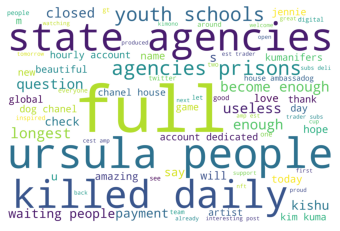

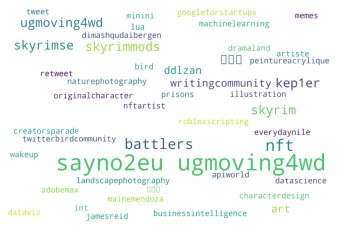

In [60]:
# generating word cloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

stopwords = set(STOPWORDS)
stopwords.update(["hello", "world"])

# word cloud for text
wc_fig = plt.figure()
word_cloud = WordCloud(background_color="white", width=3000, height=2000, max_words=75, prefer_horizontal=1.0, stopwords=stopwords)
word_cloud.generate(tweet_text)
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

# word cloud for hashtags
word_cloud = WordCloud(background_color="white", width=3000, height=2000, max_words=75, prefer_horizontal=1.0, stopwords=stopwords)
word_cloud.generate(" ".join(hash_list))
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

In [62]:
def word_cloud(df, save_img=False, filename="wordcloud.png"):
    # combining DataFrame text column into one long string, doing some initial pre-processing
    import pandas as pd
    tweet_text = " ".join(df["text"])
    tweet_text = tweet_text.lower()
    tweet_text = tweet_text.replace("\n", " ")
    
    # splitting string into list of words, removing hashtags, usernames, links, and retweet indicator
    word_list = tweet_text.split(" ")
    hash_list = [word for word in word_list if word.startswith("#")]
    user_list = [word for word in word_list if word.startswith("@")]
    link_list = [word for word in word_list if word.startswith("http")]
    word_list = [word for word in word_list if word not in hash_list + user_list + link_list]
    word_list = [word for word in word_list if word != "rt"]
    
    # using nltk tokenizer to further pre-process text, removing non-alpha words
    from nltk.tokenize import word_tokenize
    nltk.download('punkt')
    tweet_text = " ".join(word_list)
    word_list = word_tokenize(tweet_text)
    word_list = [word for word in word_list if word.isalpha()]
    
    # joining list of words into final cleaned string
    tweet_text = " ".join(word_list)
    
    # generating word cloud
    from wordcloud import WordCloud, STOPWORDS
    import matplotlib.pyplot as plt

    stopwords = set(STOPWORDS)
    stopwords.update(["hello", "world"])

    # word cloud for text
    words_fig = plt.figure()
    word_cloud = WordCloud(background_color="white", width=3000, height=2000, max_words=75, prefer_horizontal=1.0, stopwords=stopwords)
    word_cloud.generate(tweet_text)
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.show()

    # word cloud for hashtags
    hash_fig = plt.figure()
    word_cloud = WordCloud(background_color="white", width=3000, height=2000, max_words=75, prefer_horizontal=1.0, stopwords=stopwords)
    word_cloud.generate(" ".join(hash_list))
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.show()
    
    return words_fig, hash_fig

[nltk_data] Downloading package punkt to /home/lana-e/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


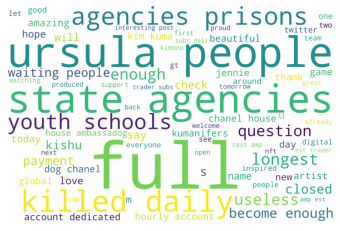

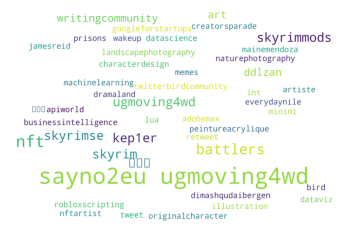

(<Figure size 432x288 with 1 Axes>, <Figure size 432x288 with 1 Axes>)

In [63]:
word_cloud(test)